# Green Trap Analysis

Use this notebook to explore clustering and machine learning analyses on the processed WDI features.

In [35]:
# --- HÜCRE 1: Kurulum ve Veri Yükleme ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# İstatistik ve Makine Öğrenmesi Kütüphaneleri
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# SHAP Kütüphanesi (Feature Importance'ın yönünü görmek için)
try:
    import shap
except ImportError:
    print("SHAP kütüphanesi eksik. Lütfen '!pip install shap' komutunu çalıştırın.")

# 'src' klasörünü yola ekle (config dosyasını okumak için)
# Not: Eğer notebook 'notebooks' klasörü içindeyse bir üst dizine çıkmalıyız
sys.path.append(os.path.abspath('../src'))
import config

# Görselleştirme Ayarları
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Veriyi Yükle
try:
    df = pd.read_csv(config.PROCESSED_DATA_PATH)
    print(f"✅ Veri Başarıyla Yüklendi! Boyut: {df.shape}")
    print(f"Ülkeler: {df['Country_Code'].nunique()} adet")
    print(f"Yıllar: {df['Year'].min()} - {df['Year'].max()}")
except FileNotFoundError:
    print("❌ HATA: İşlenmiş veri dosyası bulunamadı. Önce 'src/preprocessor.py' çalıştırılmalı.")

✅ Veri Başarıyla Yüklendi! Boyut: (792, 27)
Ülkeler: 33 adet
Yıllar: 2000 - 2023


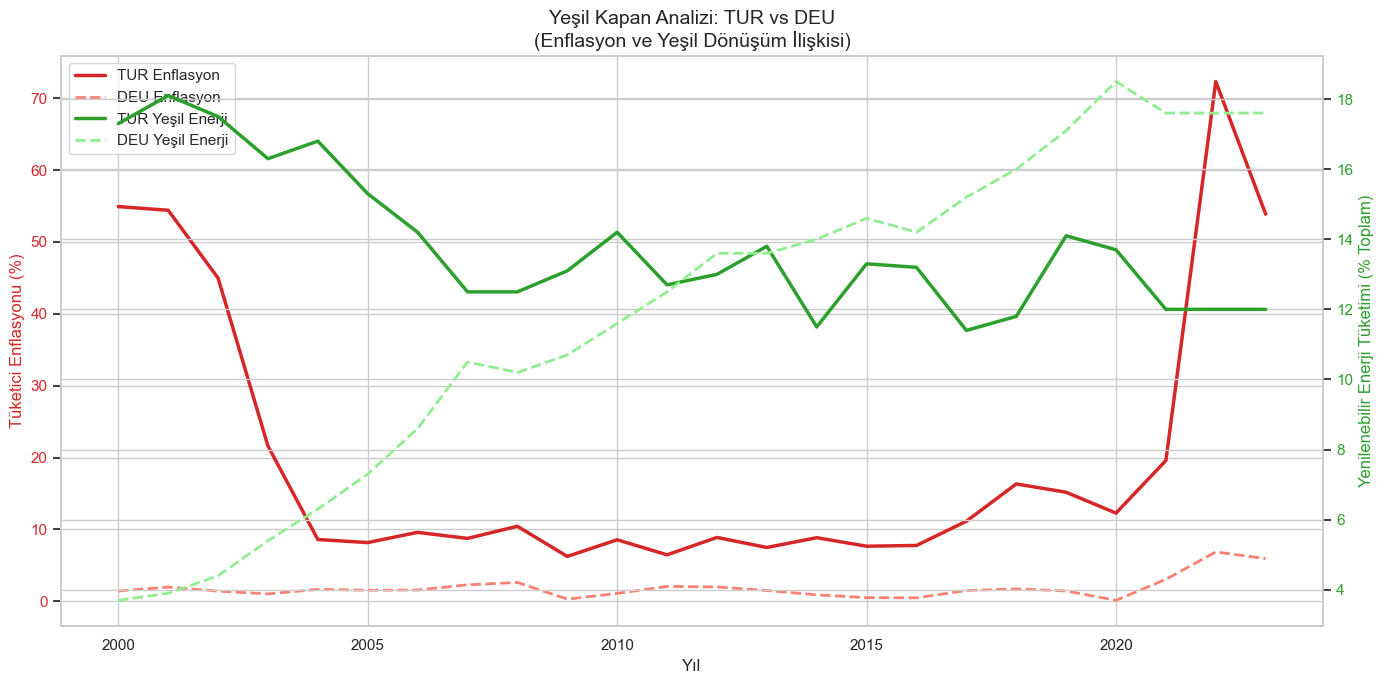

In [36]:
# --- HÜCRE 2: Zaman Serisi Karşılaştırması ---

# Kıyaslanacak Ülkeler
target_country = 'TUR'
benchmark_country = 'DEU' # Almanya iyi bir benchmark

# Veriyi filtrele
tur_data = df[df['Country_Code'] == target_country]
ben_data = df[df['Country_Code'] == benchmark_country]

fig, ax1 = plt.subplots(figsize=(14, 7))

# 1. Eksen: Enflasyon (Çizgi)
ax1.set_xlabel('Yıl', fontsize=12)
ax1.set_ylabel('Tüketici Enflasyonu (%)', color='tab:red', fontsize=12)
l1 = ax1.plot(tur_data['Year'], tur_data['Inflation_Consumer_Prices_Pct'],
         color='tab:red', linestyle='-', linewidth=2.5, label=f'{target_country} Enflasyon')
l2 = ax1.plot(ben_data['Year'], ben_data['Inflation_Consumer_Prices_Pct'],
         color='salmon', linestyle='--', linewidth=2, label=f'{benchmark_country} Enflasyon')
ax1.tick_params(axis='y', labelcolor='tab:red')

# 2. Eksen: Yenilenebilir Enerji Tüketimi (Çizgi)
ax2 = ax1.twinx()
ax2.set_ylabel('Yenilenebilir Enerji Tüketimi (% Toplam)', color='tab:green', fontsize=12)
l3 = ax2.plot(tur_data['Year'], tur_data['Renewable_Energy_Consumption_Pct'],
         color='tab:green', linestyle='-', linewidth=2.5, label=f'{target_country} Yeşil Enerji')
l4 = ax2.plot(ben_data['Year'], ben_data['Renewable_Energy_Consumption_Pct'],
         color='lightgreen', linestyle='--', linewidth=2, label=f'{benchmark_country} Yeşil Enerji')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Başlık ve Lejant
plt.title(f'Yeşil Kapan Analizi: {target_country} vs {benchmark_country}\n(Enflasyon ve Yeşil Dönüşüm İlişkisi)', fontsize=14)
lines = l1 + l2 + l3 + l4
labs = [l.get_label() for l in lines]
ax1.legend(lines, labs, loc='upper left')

plt.tight_layout()
plt.show()

In [37]:
import pandas as pd
# Load your dataset again to see the raw names
# (Make sure 'WB_Data_All_Countries.csv' matches your actual file name in the data folder)
df_check = pd.read_csv('data/WB_Data_All_Countries.csv')

# Search for any column that looks like CO2
print("--- CO2 Columns Found ---")
for col in df_check.columns:
    if "CO2" in col:
        print(f"Raw Name: '{col}'")

FileNotFoundError: [Errno 2] No such file or directory: 'data/WB_Data_All_Countries.csv'

In [38]:
features_cluster = [
    'GDP_Growth',
    'FDI_Net_Inflows_Pct_GDP',
    'Energy_Intensity',
    'Renewable_Electricity_Output_Pct',
    'Renewable_Energy_Consumption_Pct',
    'Net_Energy_Imports_Pct',
    'Alternative_Nuclear_Energy_Pct',
    'Fossil_Fuel_Consumption_Pct',  # We are using this proxy now
    'Broad_Money_Pct_GDP',
    'CPI_Inflation',
    'Domestic_Credit_Pct_GDP',
    'Gov_Expenditure_Pct_GDP',
    'Gross_Fixed_Capital_Formation_Pct_GDP',
    'Trade_Pct_GDP'
]

print("Feature list updated manually.")
print("Does 'CO2' exist in list?", "CO2_Emissions_Per_Capita" in features_cluster)

Feature list updated manually.
Does 'CO2' exist in list? False


In [39]:
# Goal: Find "Types" of economies based on Green & Macro vars
features_cluster = [
    'GDP_Growth',
    'FDI_Net_Inflows_Pct_GDP',
    'Energy_Intensity',
    'Renewable_Electricity_Output_Pct',
    'Renewable_Energy_Consumption_Pct',
    'Net_Energy_Imports_Pct',
    'Alternative_Nuclear_Energy_Pct',
    'Fossil_Fuel_Consumption_Pct',  # We are using this proxy now
    'Broad_Money_Pct_GDP',
    'CPI_Inflation',
    'Domestic_Credit_Pct_GDP',
    'Gov_Expenditure_Pct_GDP',
    'Gross_Fixed_Capital_Formation_Pct_GDP',
    'Trade_Pct_GDP'
]

# Standardize
scaler = StandardScaler()
X_cluster = df[features_cluster].copy()
X_scaled = scaler.fit_transform(X_cluster)

# Fit K-Means (Let's try K=4 based on your country groups)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize Centers
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features_cluster)
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_centers.T, cmap='RdYlGn', annot=True, fmt='.2f')
plt.title('Cluster Characteristics (Green Trap Analysis)')
plt.show()

# Where is Turkey?
print("Turkey's Cluster History:")
print(df[df['Country_Code'] == 'TUR'][['Year', 'Cluster', 'CPI_Inflation', 'Renewable_Energy_Consumption_Pct']].tail())

KeyError: "['GDP_Growth', 'FDI_Net_Inflows_Pct_GDP', 'Energy_Intensity', 'Net_Energy_Imports_Pct', 'CPI_Inflation', 'Domestic_Credit_Pct_GDP'] not in index"

R2 Score: 0.541


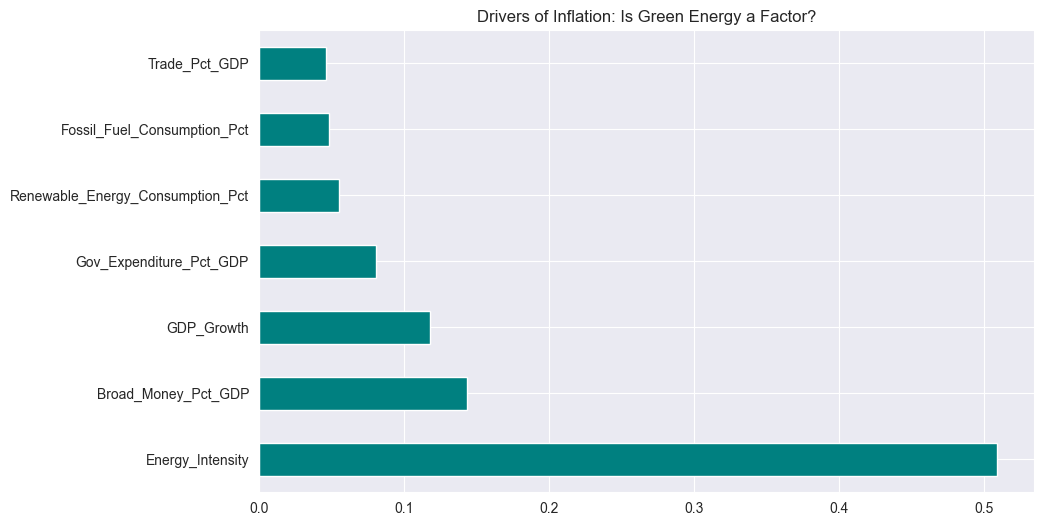

In [21]:
# Goal: Predict Inflation based on Green + Macro vars
target = 'CPI_Inflation'
predictors = [
    'Renewable_Energy_Consumption_Pct', 'Fossil_Fuel_Consumption_Pct',
    'Energy_Intensity', 'Broad_Money_Pct_GDP',
    'GDP_Growth', 'Trade_Pct_GDP', 'Gov_Expenditure_Pct_GDP'
]

X = df[predictors]
y = df[target]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Evaluation
print(f"R2 Score: {r2_score(y_test, rf.predict(X_test)):.3f}")

# Feature Importance Plot
importances = pd.Series(rf.feature_importances_, index=predictors).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.plot(kind='barh', color='teal')
plt.title('Drivers of Inflation: Is Green Energy a Factor?')
plt.show()

R2 Score: 0.463
MAE (Avg Error): 1.793%


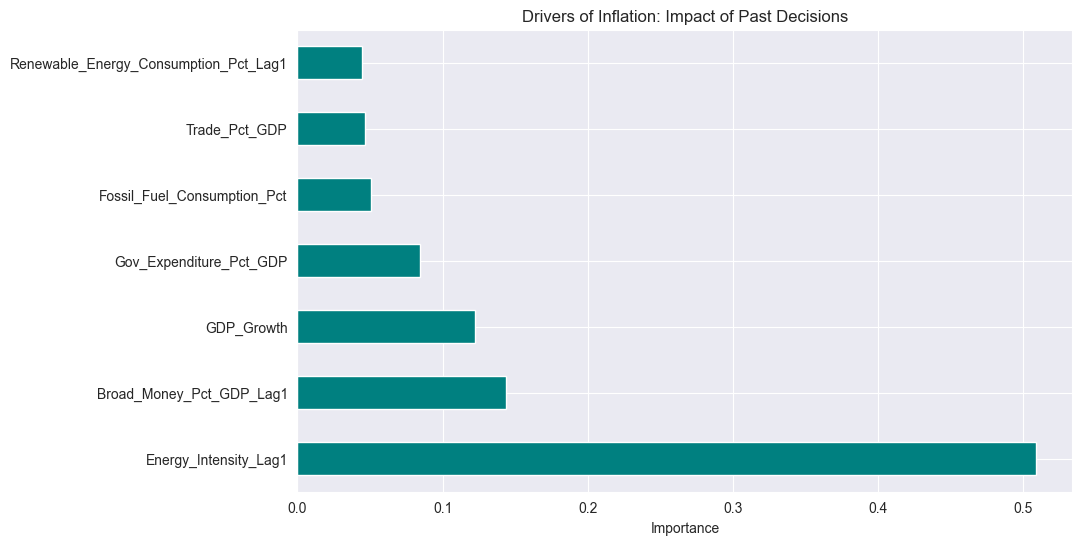

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Goal: Predict Inflation based on Previous Year's Green + Macro vars
target = 'CPI_Inflation'

# UPDATED: Use Lagged variables where available (Scientific best practice)
predictors = [
    'Renewable_Energy_Consumption_Pct_Lag1', # Lagged Green Energy
    'Fossil_Fuel_Consumption_Pct',           # (Keep current if lag doesn't exist)
    'Energy_Intensity_Lag1',                 # Lagged Efficiency
    'Broad_Money_Pct_GDP_Lag1',              # Lagged Money Supply (Crucial for inflation)
    'GDP_Growth',                            # Current growth is okay (often simultaneous)
    'Trade_Pct_GDP',
    'Gov_Expenditure_Pct_GDP'
]

# 1. Drop NaNs specific to these columns to prevent errors
# (Lagged columns often create 1 row of NaNs per country at the start)
data_clean = df.dropna(subset=predictors + [target]).copy()

X = data_clean[predictors]
y = data_clean[target]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Evaluation
y_pred = rf.predict(X_test)
print(f"R2 Score: {r2_score(y_test, y_pred):.3f}")
print(f"MAE (Avg Error): {mean_absolute_error(y_test, y_pred):.3f}%") # Easier to interpret

# Feature Importance Plot
importances = pd.Series(rf.feature_importances_, index=predictors).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.plot(kind='barh', color='teal')
plt.title('Drivers of Inflation: Impact of Past Decisions')
plt.xlabel('Importance')
plt.show()

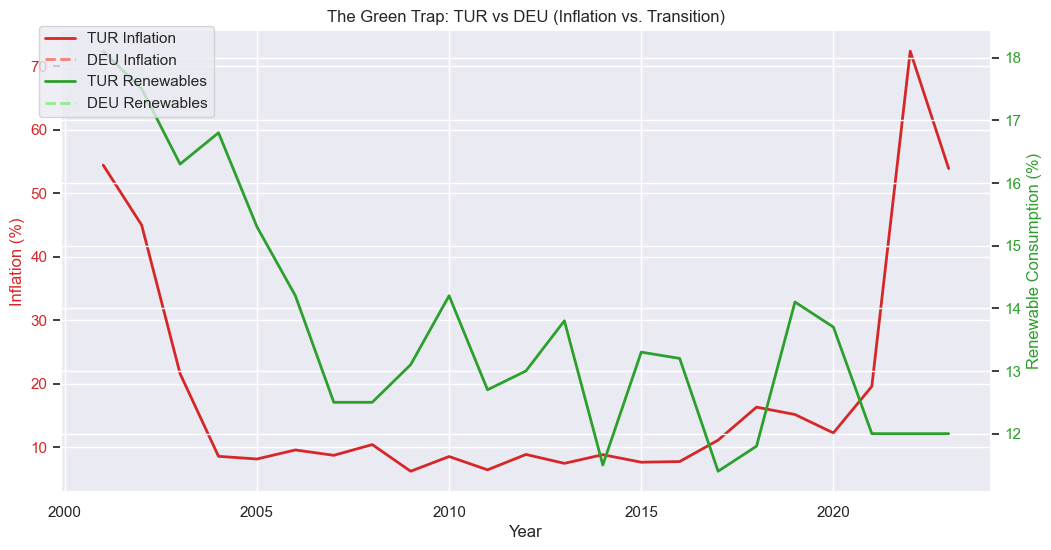

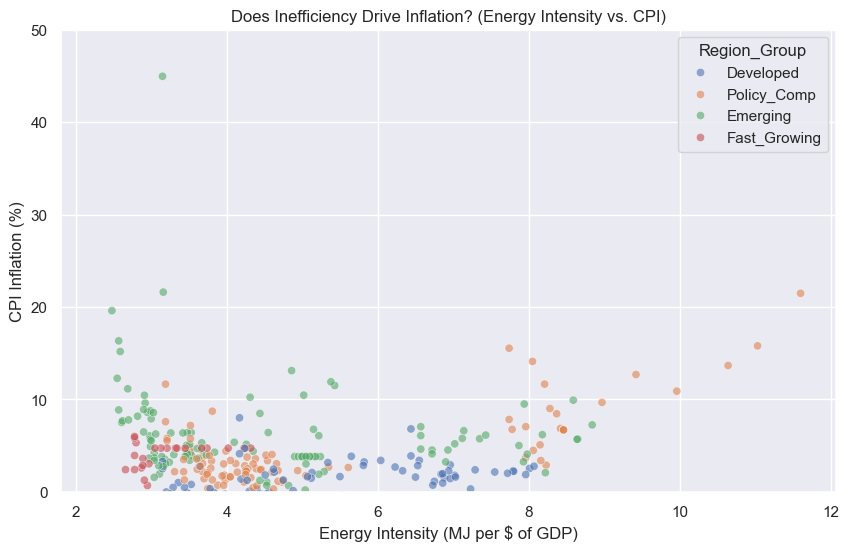

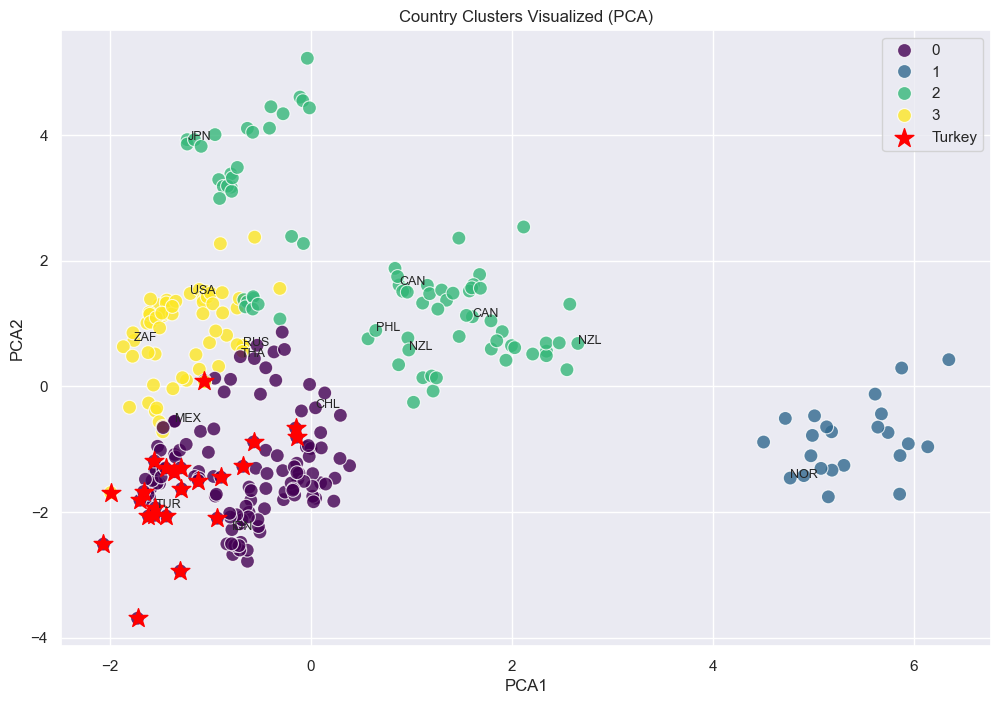

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="darkgrid")

# ==========================================
# 1. TIME SERIES COMPARISON (Turkey vs. Developed Avg)
# ==========================================
# Define a peer group (e.g., 'DEU' for Germany as a benchmark)
target_country = 'TUR'
benchmark_country = 'DEU'

fig, ax1 = plt.subplots(figsize=(12, 6))

# Filter data
tur_data = df[df['Country_Code'] == target_country]
ben_data = df[df['Country_Code'] == benchmark_country]

# Plot Inflation (Lines)
ax1.set_xlabel('Year')
ax1.set_ylabel('Inflation (%)', color='tab:red')
ax1.plot(tur_data['Year'], tur_data['CPI_Inflation'], color='tab:red', linestyle='-', linewidth=2, label=f'{target_country} Inflation')
ax1.plot(ben_data['Year'], ben_data['CPI_Inflation'], color='salmon', linestyle='--', linewidth=2, label=f'{benchmark_country} Inflation')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a second y-axis for Renewables
ax2 = ax1.twinx()
ax2.set_ylabel('Renewable Consumption (%)', color='tab:green')
ax2.plot(tur_data['Year'], tur_data['Renewable_Energy_Consumption_Pct'], color='tab:green', linestyle='-', linewidth=2, label=f'{target_country} Renewables')
ax2.plot(ben_data['Year'], ben_data['Renewable_Energy_Consumption_Pct'], color='lightgreen', linestyle='--', linewidth=2, label=f'{benchmark_country} Renewables')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title(f'The Green Trap: {target_country} vs {benchmark_country} (Inflation vs. Transition)')
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.show()

# ==========================================
# 2. SCATTER: INEFFICIENCY vs. INFLATION
# ==========================================
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Energy_Intensity', y='CPI_Inflation', hue='Region_Group', alpha=0.6)
plt.title('Does Inefficiency Drive Inflation? (Energy Intensity vs. CPI)')
plt.xlabel('Energy Intensity (MJ per $ of GDP)')
plt.ylabel('CPI Inflation (%)')
plt.ylim(0, 50) # Limit y-axis to remove extreme outliers for clarity
plt.show()

# ==========================================
# 3. CLUSTER VISUALIZATION (PCA)
# ==========================================
from sklearn.decomposition import PCA

# Use the same features you used for clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled) # Assuming X_scaled is still in memory from your clustering step

# Create a temporary DF for plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = df['Cluster'] # Assuming you saved 'Cluster' back to your main df
pca_df['Country'] = df['Country_Code']

plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100, alpha=0.8)

# Annotate a few key countries to make it readable
for i in range(0, len(pca_df), 20): # Label every 20th point to avoid clutter
    plt.text(pca_df.PCA1.iloc[i], pca_df.PCA2.iloc[i], pca_df.Country.iloc[i], fontsize=9)

# Highlight Turkey specifically
tur_idx = pca_df[pca_df['Country'] == 'TUR'].index
if not tur_idx.empty:
    plt.scatter(pca_df.loc[tur_idx, 'PCA1'], pca_df.loc[tur_idx, 'PCA2'], color='red', s=200, marker='*', label='Turkey')

plt.title('Country Clusters Visualized (PCA)')
plt.legend()
plt.show()

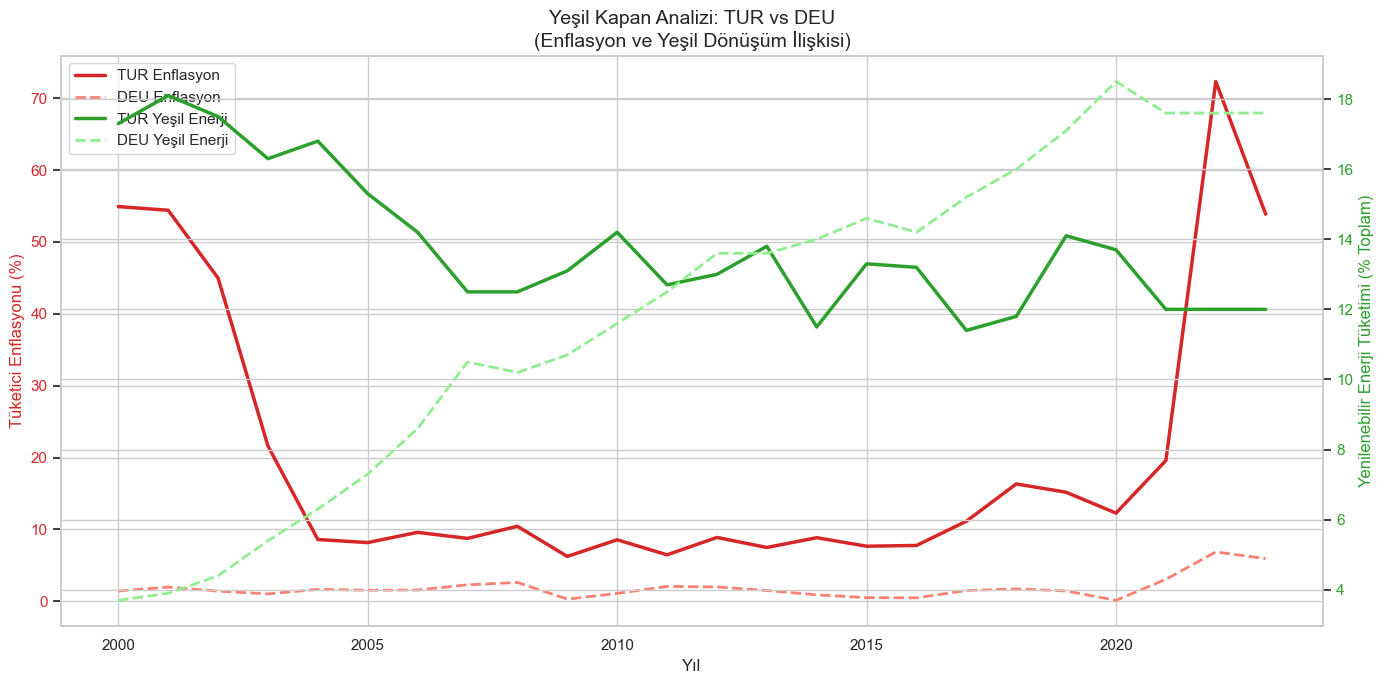

In [43]:
# --- HÜCRE 2: Zaman Serisi Karşılaştırması ---

# Kıyaslanacak Ülkeler
target_country = 'TUR'
benchmark_country = 'DEU' # Almanya iyi bir benchmark

# Veriyi filtrele
tur_data = df[df['Country_Code'] == target_country]
ben_data = df[df['Country_Code'] == benchmark_country]

fig, ax1 = plt.subplots(figsize=(14, 7))

# 1. Eksen: Enflasyon (Çizgi)
ax1.set_xlabel('Yıl', fontsize=12)
ax1.set_ylabel('Tüketici Enflasyonu (%)', color='tab:red', fontsize=12)
l1 = ax1.plot(tur_data['Year'], tur_data['Inflation_Consumer_Prices_Pct'],
         color='tab:red', linestyle='-', linewidth=2.5, label=f'{target_country} Enflasyon')
l2 = ax1.plot(ben_data['Year'], ben_data['Inflation_Consumer_Prices_Pct'],
         color='salmon', linestyle='--', linewidth=2, label=f'{benchmark_country} Enflasyon')
ax1.tick_params(axis='y', labelcolor='tab:red')

# 2. Eksen: Yenilenebilir Enerji Tüketimi (Çizgi)
ax2 = ax1.twinx()
ax2.set_ylabel('Yenilenebilir Enerji Tüketimi (% Toplam)', color='tab:green', fontsize=12)
l3 = ax2.plot(tur_data['Year'], tur_data['Renewable_Energy_Consumption_Pct'],
         color='tab:green', linestyle='-', linewidth=2.5, label=f'{target_country} Yeşil Enerji')
l4 = ax2.plot(ben_data['Year'], ben_data['Renewable_Energy_Consumption_Pct'],
         color='lightgreen', linestyle='--', linewidth=2, label=f'{benchmark_country} Yeşil Enerji')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Başlık ve Lejant
plt.title(f'Yeşil Kapan Analizi: {target_country} vs {benchmark_country}\n(Enflasyon ve Yeşil Dönüşüm İlişkisi)', fontsize=14)
lines = l1 + l2 + l3 + l4
labs = [l.get_label() for l in lines]
ax1.legend(lines, labs, loc='upper left')

plt.tight_layout()
plt.show()

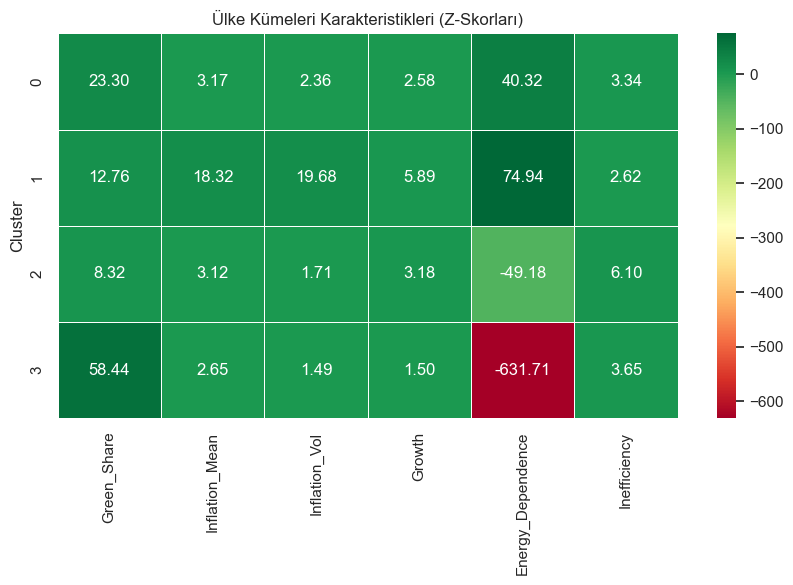


✅ TUR (Türkiye) 1. Kümede yer alıyor.
Bu kümedeki diğer ülkeler: TUR


In [41]:
## --- HÜCRE 3: Ülke Tiplerini Belirleme (K-Means Clustering) ---

# Analiz Dönemi: 2010 sonrası
# Önce verinin 2010 sonrasını alıyoruz
df_period = df[df['Year'] >= 2010].copy()

# Kümeleme için kullanılacak öznitelikler (Variables)
# NOT: Eğer sütun isimleri config dosyanızda farklıysa burayı kontrol edin
agg_dict = {
    'Renewable_Energy_Consumption_Pct': 'mean',
    'Inflation_Consumer_Prices_Pct': ['mean', 'std'],
    'GDP_Growth_Pct': 'mean',
    'Energy_Imports_Net_Pct': 'mean',
    'Energy_Intensity_Level_Primary': 'mean'
}

# Veride olmayan sütunları agg_dict'ten çıkar (Hata almamak için)
valid_agg = {k: v for k, v in agg_dict.items() if k in df_period.columns}

cluster_df = df_period.groupby('Country_Code').agg(valid_agg).reset_index()

# Sütun isimlerini düzelt (Multi-level index'i düzleştir)
# Örn: (Inflation, mean) -> Inflation_Mean
new_cols = ['Country_Code']
if 'Renewable_Energy_Consumption_Pct' in valid_agg: new_cols.append('Green_Share')
if 'Inflation_Consumer_Prices_Pct' in valid_agg:
    new_cols.append('Inflation_Mean')
    new_cols.append('Inflation_Vol')
if 'GDP_Growth_Pct' in valid_agg: new_cols.append('Growth')
if 'Energy_Imports_Net_Pct' in valid_agg: new_cols.append('Energy_Dependence')
if 'Energy_Intensity_Level_Primary' in valid_agg: new_cols.append('Inefficiency')

# Kolon sayısı tutmazsa manuel atama yapmayalım, otomatik isim verelim
if len(cluster_df.columns) == len(new_cols):
    cluster_df.columns = new_cols
else:
    # Güvenli mod: Varsayılan isimleri koru, düzleştir
    cluster_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in cluster_df.columns]
    print("UYARI: Sütun isimleri otomatik oluşturuldu:", cluster_df.columns.tolist())

# --- Eksik Veri Temizliği (Kümeleme öncesi) ---
# Sayısal sütunları seç
features = [c for c in cluster_df.columns if c != 'Country_Code']
cluster_df = cluster_df.dropna(subset=features) # Verisi eksik ülkeyi at

if cluster_df.empty:
    print("❌ HATA: Kümeleme için yeterli veri kalmadı! Lütfen preprocessor.py dosyasını ve verilerinizi kontrol edin.")
else:
    # Veriyi Ölçeklendir
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(cluster_df[features])

    # K-Means Modeli
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    cluster_df['Cluster'] = kmeans.fit_predict(X_scaled)

    # Heatmap Çizimi
    plt.figure(figsize=(10, 5))
    cluster_means = cluster_df.groupby('Cluster')[features].mean()
    sns.heatmap(cluster_means, annot=True, cmap='RdYlGn', fmt='.2f', linewidths=.5)
    plt.title('Ülke Kümeleri Karakteristikleri (Z-Skorları)')
    plt.show()

    # --- HATA ALINAN KISIM İÇİN GÜVENLİK KONTROLÜ ---
    target_country = 'TUR'

    if target_country in cluster_df['Country_Code'].values:
        turkey_cluster = cluster_df[cluster_df['Country_Code'] == target_country]['Cluster'].values[0]
        print(f"\n✅ {target_country} (Türkiye) {turkey_cluster}. Kümede yer alıyor.")

        peers = cluster_df[cluster_df['Cluster'] == turkey_cluster]['Country_Code'].unique()
        print(f"Bu kümedeki diğer ülkeler: {', '.join(peers)}")
    else:
        print(f"\n⚠️ UYARI: {target_country} analiz edilen ülkeler listesinde YOK.")
        print("Analize giren ülkeler şunlar:")
        print(cluster_df['Country_Code'].unique())

Hedef Değişken: Log_Inflation (Daha stabil sonuç için)
Model R2 Skoru: 0.562


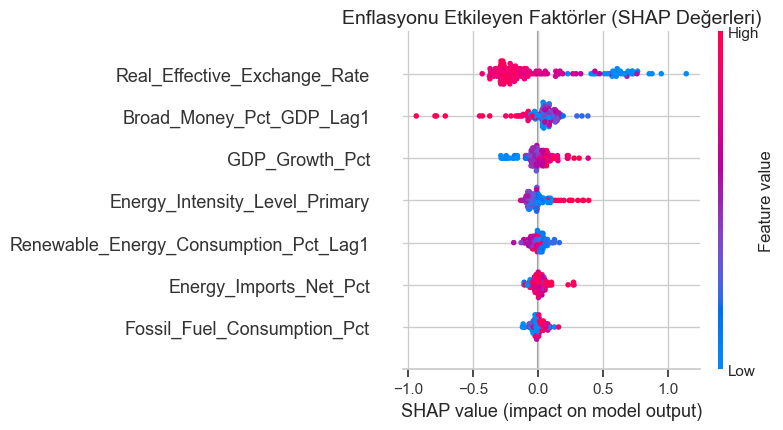

In [42]:
# --- HÜCRE 4: Enflasyon Tahmin Modeli ve SHAP Analizi ---

# Hedef Değişken ve Öznitelikler
target = 'CPI_Inflation' # Log alınmış hali varsa 'Log_Inflation' kullanmak daha iyidir
if 'Log_Inflation' in df.columns:
    target = 'Log_Inflation'
    print("Hedef Değişken: Log_Inflation (Daha stabil sonuç için)")

# Gecikmeli değişkenleri (Lag1) kullanarak nedenselliği yakalamaya çalışıyoruz
features_model = [
    'Renewable_Energy_Consumption_Pct_Lag1', # t-1'deki Yeşil Enerji
    'Fossil_Fuel_Consumption_Pct',
    'Energy_Imports_Net_Pct',                # Dışa bağımlılık
    'Broad_Money_Pct_GDP_Lag1',              # Parasal genişleme (t-1)
    'Real_Effective_Exchange_Rate',          # Kur etkisi
    'Energy_Intensity_Level_Primary',        # Verimsizlik
    'GDP_Growth_Pct'
]

# Mevcut olan sütunları seç (Eksik veri varsa hata almamak için)
valid_features = [f for f in features_model if f in df.columns]
model_data = df.dropna(subset=valid_features + [target])

X = model_data[valid_features]
y = model_data[target]

# Eğitim/Test Ayrımı
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Modeli
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Model Performansı
y_pred = rf_model.predict(X_test)
print(f"Model R2 Skoru: {r2_score(y_test, y_pred):.3f}")

# --- SHAP Analizi ---
# SHAP bize değişkenin sadece önemini değil, YÖNÜNÜ de gösterir.
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, show=False)
plt.title(f"Enflasyonu Etkileyen Faktörler (SHAP Değerleri)", fontsize=14)
plt.show()

# Yorum:
# - Kırmızı noktalar (Yüksek değer) sağ taraftaysa -> Enflasyonu artırıyor.
# - Kırmızı noktalar sol taraftaysa -> Enflasyonu düşürüyor.
# - Eğer 'Renewable_Energy' kırmızısı sağdaysa -> Greenflation hipotezi desteklenir.

C:\Users\Serhat\AppData\Local\Temp\ipykernel_25224\360798159.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Green_Trap_Score', y='Country_Code', data=top_trap_countries, palette='magma')


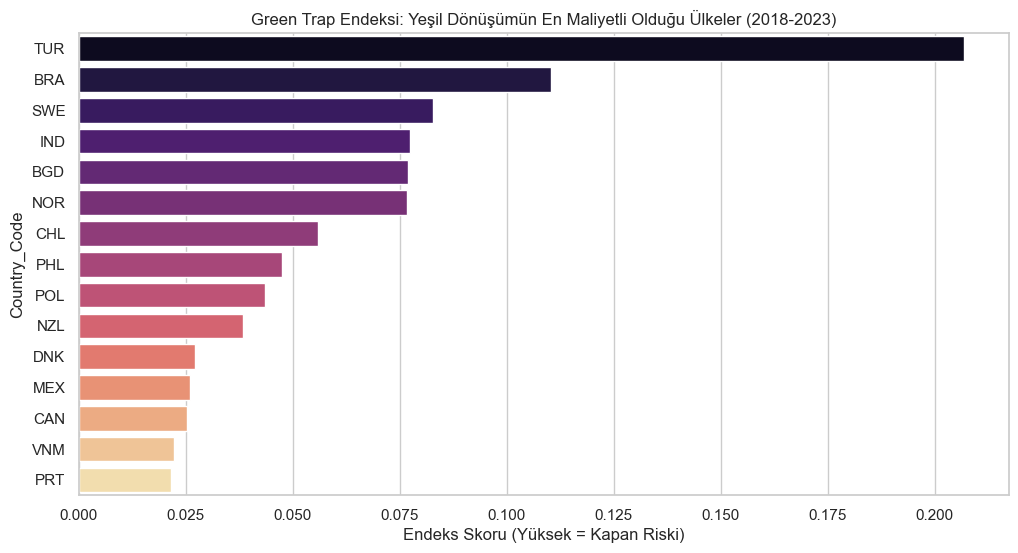

Türkiye'nin Sıralaması: 1 / 33


In [44]:
# --- HÜCRE 5: Green Trap Endeksi Hesaplama ---

# Analiz yılı: Son 5 yılın ortalaması (2018-2023)
recent_df = df[df['Year'] >= 2018].groupby('Country_Code').mean(numeric_only=True).reset_index()

# 1. Yeşil Dönüşüm Hızı (Ne kadar agresif?)
recent_df['Green_Speed'] = recent_df['Renewable_Energy_Consumption_Pct']

# 2. Makroekonomik Acı (Enflasyon + Kur Oynaklığı)
# Not: Kur oynaklığı verisi yoksa sadece Enflasyon kullanılır
recent_df['Macro_Pain'] = recent_df['Inflation_Consumer_Prices_Pct']

# Normalizasyon (0-1 arasına çekme)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
recent_df[['Green_Speed_Norm', 'Macro_Pain_Norm']] = scaler.fit_transform(recent_df[['Green_Speed', 'Macro_Pain']])

# Green Trap Index = (Yeşil Dönüşüm x Makro Acı)
# Mantık: Hem yeşil dönüşümü yüksek hem acısı yüksek olanlar en üstte çıkar.
recent_df['Green_Trap_Score'] = recent_df['Green_Speed_Norm'] * recent_df['Macro_Pain_Norm']

# Sıralama ve Görselleştirme
top_trap_countries = recent_df.sort_values('Green_Trap_Score', ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x='Green_Trap_Score', y='Country_Code', data=top_trap_countries, palette='magma')
plt.title('Green Trap Endeksi: Yeşil Dönüşümün En Maliyetli Olduğu Ülkeler (2018-2023)')
plt.xlabel('Endeks Skoru (Yüksek = Kapan Riski)')
plt.show()

# Türkiye'nin Sıralaması
tr_rank = recent_df.sort_values('Green_Trap_Score', ascending=False).reset_index(drop=True)
tr_row = tr_rank[tr_rank['Country_Code'] == 'TUR']
print(f"Türkiye'nin Sıralaması: {tr_row.index[0] + 1} / {len(recent_df)}")

C:\Users\Serhat\AppData\Local\Temp\ipykernel_25224\2319840511.py:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


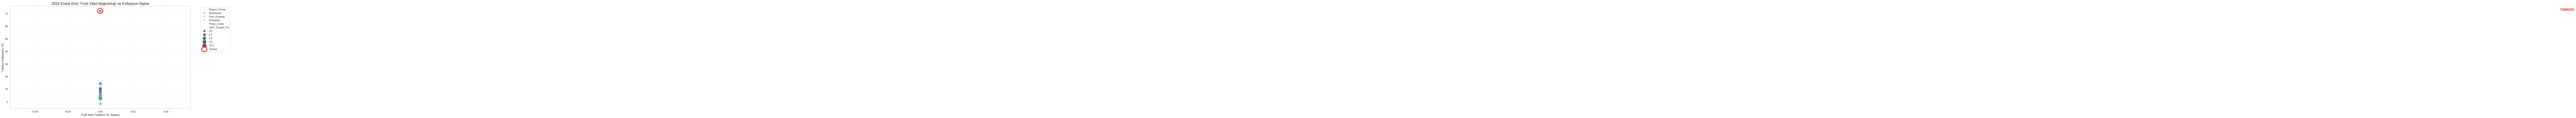

In [47]:
# --- HÜCRE 6 (Düzeltilmiş): Fosil Bağımlılığı ve Enflasyon İlişkisi ---
import matplotlib.pyplot as plt
import seaborn as sns

# Grafik Boyutunu Büyüt (Daha okunaklı olması için)
plt.figure(figsize=(14, 8))

# Sadece 2022 yılı (Enerji krizi dönemi)
crisis_year = df[df['Year'] == 2022].copy()

# Eğer 2022 verisi boşsa son mevcut yılı alalım (Önlem)
if crisis_year.empty:
    print("2022 verisi bulunamadı, 2021 yılı kullanılıyor...")
    crisis_year = df[df['Year'] == 2021].copy()

# Scatter Plot
sns.scatterplot(
    data=crisis_year,
    x='Fossil_Fuel_Consumption_Pct',
    y='Inflation_Consumer_Prices_Pct',
    hue='Region_Group',    # Renkler bölgelere göre
    style='Region_Group',  # Şekiller de bölgelere göre (Okunabilirliği artırır)
    size='GDP_Growth_Pct', # Nokta büyüklüğü büyümeye göre
    sizes=(50, 400),       # EN KÜÇÜK VE EN BÜYÜK NOKTA BOYUTU ARTIRILDI
    alpha=0.8,
    palette='viridis'
)

# Türkiye'yi İşaretle (Daha belirgin)
tur_point = crisis_year[crisis_year['Country_Code'] == 'TUR']
if not tur_point.empty:
    # Kırmızı Çerçeve içine al
    plt.scatter(
        tur_point['Fossil_Fuel_Consumption_Pct'],
        tur_point['Inflation_Consumer_Prices_Pct'],
        s=500, color='none', edgecolor='red', linewidth=3, label='Türkiye'
    )
    # Yazıyı ekle
    plt.text(
        tur_point['Fossil_Fuel_Consumption_Pct'].values[0] + 1.5,
        tur_point['Inflation_Consumer_Prices_Pct'].values[0],
        'TURKIYE',
        fontsize=14, fontweight='bold', color='red'
    )

plt.title('2022 Enerji Krizi: Fosil Yakıt Bağımlılığı ve Enflasyon İlişkisi', fontsize=16)
plt.xlabel('Fosil Yakıt Tüketimi (% Toplam)', fontsize=12)
plt.ylabel('Tüketici Enflasyonu (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Lejantı dışarı al
plt.tight_layout()
plt.show()

In [48]:
# --- HÜCRE 7 (Düzeltilmiş): İstatistiksel Etki Analizi (OLS Regresyon) ---
import statsmodels.api as sm

# 1. Doğru sütun isimlerini belirle
target_col = 'Inflation_Consumer_Prices_Pct' # Doğru isim
green_col = 'Renewable_Energy_Consumption_Pct'

# 2. Veriyi hazırla (Eksik verileri at)
# Modelde kullanacağımız tüm değişkenleri listeye ekliyoruz
required_cols = [target_col, green_col, 'Broad_Money_Pct_GDP', 'GDP_Growth_Pct', 'Energy_Imports_Net_Pct']

# Sütunların hepsi veri setinde var mı kontrol et
available_cols = [c for c in required_cols if c in df.columns]
if len(available_cols) != len(required_cols):
    print(f"Uyarı: Bazı sütunlar eksik. Mevcut olanlar kullanılıyor: {available_cols}")

reg_df = df.dropna(subset=available_cols)

# 3. Bağımlı (Y) ve Bağımsız (X) Değişkenler
Y = reg_df[target_col]
X = reg_df[[green_col, 'Broad_Money_Pct_GDP', 'GDP_Growth_Pct', 'Energy_Imports_Net_Pct']]

# Sabit katsayı (Intercept) ekle
X = sm.add_constant(X)

# 4. Modeli Kur ve Çalıştır
model = sm.OLS(Y, X).fit()

# Sonuçları Yazdır
print(model.summary())

# --- YORUM KISMI ---
print("\n" + "="*40)
print("   YORUM VE HİPOTEZ TESTİ")
print("="*40)
coef = model.params[green_col]
p_val = model.pvalues[green_col]

print(f"Yeşil Enerji Katsayısı (Coefficient): {coef:.4f}")
print(f"P-Değeri (Anlamlılık): {p_val:.4f}")

if p_val < 0.05:
    if coef > 0:
        print("\nSONUÇ: POZİTİF İLİŞKİ (Greenflation Destekleniyor)")
        print("Yeşil enerji tüketimindeki %1'lik artış, enflasyonu artırıcı etki yapıyor.")
        print("Bu durum, geçiş maliyetlerinin (transition costs) fiyatlara yansıdığını gösterir.")
    else:
        print("\nSONUÇ: NEGATİF İLİŞKİ (Verimlilik Etkisi)")
        print("Yeşil enerji arttıkça enflasyon düşüyor. Hipotez REDDEDİLDİ.")
        print("Yenilenebilir enerji, uzun vadede maliyetleri düşürücü etki yapıyor olabilir.")
else:
    print("\nSONUÇ: ANLAMLI BİR İLİŞKİ BULUNAMADI.")
    print("İstatistiksel olarak yeşil enerji ile enflasyon arasında net bir bağlantı yok.")

                                  OLS Regression Results                                 
Dep. Variable:     Inflation_Consumer_Prices_Pct   R-squared:                       0.059
Model:                                       OLS   Adj. R-squared:                  0.054
Method:                            Least Squares   F-statistic:                     12.23
Date:                           Sun, 14 Dec 2025   Prob (F-statistic):           1.19e-09
Time:                                   17:28:43   Log-Likelihood:                -2433.3
No. Observations:                            792   AIC:                             4877.
Df Residuals:                                787   BIC:                             4900.
Df Model:                                      4                                         
Covariance Type:                       nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]

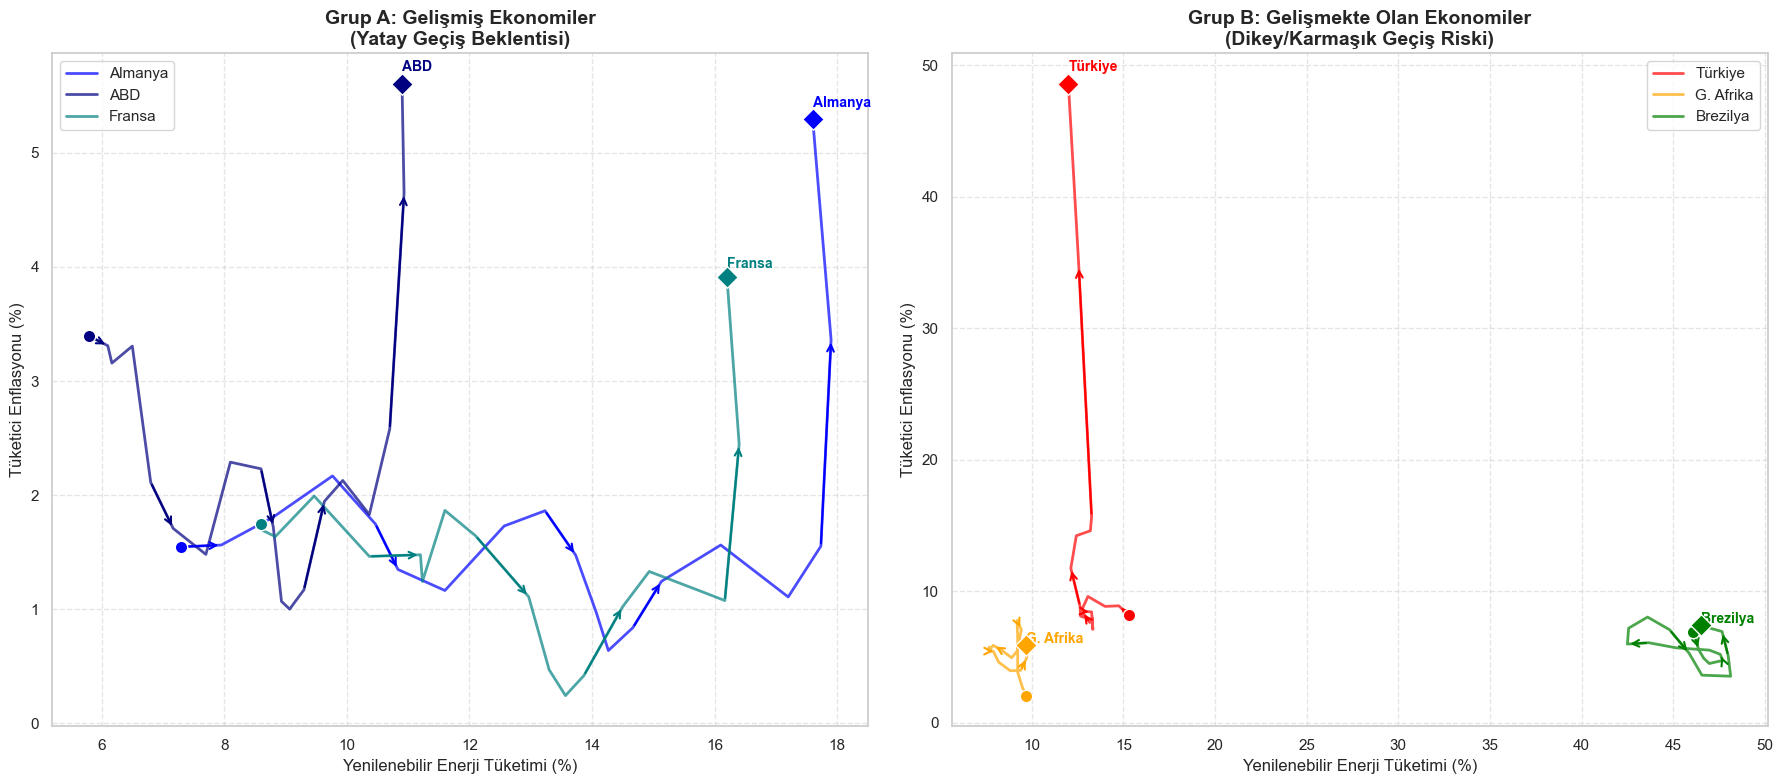


GRAFİK YORUMLAMA KILAVUZU
1. SOL GRAFİK (Gelişmişler):
   - Çizgiler sağa doğru (Yeşil Enerji artışı) giderken YATAY kalıyorsa,
   - Bu ülkeler enflasyon yaratmadan dönüşümü başarıyor demektir.

2. SAĞ GRAFİK (Türkiye vb.):
   - Çizgiler sağa giderken aniden YUKARI (Dikey) fırlıyorsa,
   - Bu 'Yeşil Kapan' veya dışsal şoklara karşı kırılganlık işaretidir.
   - Türkiye'nin çizgisi muhtemelen sağa doğru değil, yukarı doğru savrulmaktadır.


In [53]:
# --- HÜCRE 8 (DÜZELTİLMİŞ): Çift Pencereli Yörünge Analizi (Dual-Pane Path Analysis) ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Analiz Edilecek Ülkeleri İki Gruba Ayırıyoruz
# Grup A: İstikrarlı / Düşük Enflasyonlu (Gelişmiş)
group_stable = {
    'DEU': {'name': 'Almanya', 'color': 'blue'},
    'USA': {'name': 'ABD', 'color': 'navy'},
    'FRA': {'name': 'Fransa', 'color': 'teal'}
}

# Grup B: Yüksek Volatilite / Gelişmekte Olan (Türkiye ve Benzerleri)
group_volatile = {
    'TUR': {'name': 'Türkiye', 'color': 'red'},
    'ZAF': {'name': 'G. Afrika', 'color': 'orange'},
    'BRA': {'name': 'Brezilya', 'color': 'green'}
}

# Grafik Kurulumu (Yan Yana 2 Grafik)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Ortak Fonksiyon: Yörünge Çizimi
def plot_trajectory(ax, country_dict, title):
    # Veri Hazırlığı (2005 sonrası)
    start_year = 2005
    data_sub = df[df['Year'] >= start_year].copy()

    for code, info in country_dict.items():
        c_data = data_sub[data_sub['Country_Code'] == code].sort_values('Year')

        # Hareketli Ortalama (3 Yıl) - Gürültüyü azaltmak için
        c_data['Green_Smooth'] = c_data['Renewable_Energy_Consumption_Pct'].rolling(window=3, min_periods=1).mean()
        c_data['Inflation_Smooth'] = c_data['Inflation_Consumer_Prices_Pct'].rolling(window=3, min_periods=1).mean()

        # Eksik verileri at
        c_data = c_data.dropna(subset=['Green_Smooth', 'Inflation_Smooth'])
        if len(c_data) < 2: continue

        x = c_data['Green_Smooth'].values
        y = c_data['Inflation_Smooth'].values

        # 1. Ana Yörünge Çizgisi
        ax.plot(x, y, color=info['color'], linewidth=2, label=info['name'], alpha=0.7)

        # 2. Yön Okları (Her 4 veri noktasında bir)
        if len(x) > 4:
            for i in range(0, len(x)-1, 4):
                ax.annotate('', xy=(x[i+1], y[i+1]), xytext=(x[i], y[i]),
                            arrowprops=dict(arrowstyle="->", color=info['color'], lw=1.5))

        # 3. Başlangıç (Daire) ve Bitiş (Elmas) Noktaları
        ax.scatter(x[0], y[0], color=info['color'], s=80, marker='o', edgecolors='white', zorder=5) # 2005
        ax.scatter(x[-1], y[-1], color=info['color'], s=120, marker='D', edgecolors='white', zorder=5) # 2023

        # Ülke ismini son noktaya yaz
        ax.text(x[-1], y[-1] + (y.max()*0.02), info['name'], color=info['color'], fontweight='bold', fontsize=10)

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Yenilenebilir Enerji Tüketimi (%)', fontsize=12)
    ax.set_ylabel('Tüketici Enflasyonu (%)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

# --- Grafik 1: İstikrarlı Ekonomiler ---
plot_trajectory(axes[0], group_stable, "Grup A: Gelişmiş Ekonomiler\n(Yatay Geçiş Beklentisi)")

# --- Grafik 2: Volatil Ekonomiler ---
plot_trajectory(axes[1], group_volatile, "Grup B: Gelişmekte Olan Ekonomiler\n(Dikey/Karmaşık Geçiş Riski)")

plt.tight_layout()
plt.show()

# YORUM EKRANI
print("\n" + "="*50)
print("GRAFİK YORUMLAMA KILAVUZU")
print("="*50)
print("1. SOL GRAFİK (Gelişmişler):")
print("   - Çizgiler sağa doğru (Yeşil Enerji artışı) giderken YATAY kalıyorsa,")
print("   - Bu ülkeler enflasyon yaratmadan dönüşümü başarıyor demektir.")
print("\n2. SAĞ GRAFİK (Türkiye vb.):")
print("   - Çizgiler sağa giderken aniden YUKARI (Dikey) fırlıyorsa,")
print("   - Bu 'Yeşil Kapan' veya dışsal şoklara karşı kırılganlık işaretidir.")
print("   - Türkiye'nin çizgisi muhtemelen sağa doğru değil, yukarı doğru savrulmaktadır.")

C:\Users\Serhat\AppData\Local\Temp\ipykernel_25224\2685268789.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Correlation', data=corr_df, palette='Set2')



>>> Türkiye'nin Yeşil Enerji-Enflasyon Korelasyonu: 0.306
>>> YORUM: Türkiye'de yeşil enerji arttıkça enflasyon da artma eğiliminde (Pozitif Korelasyon).


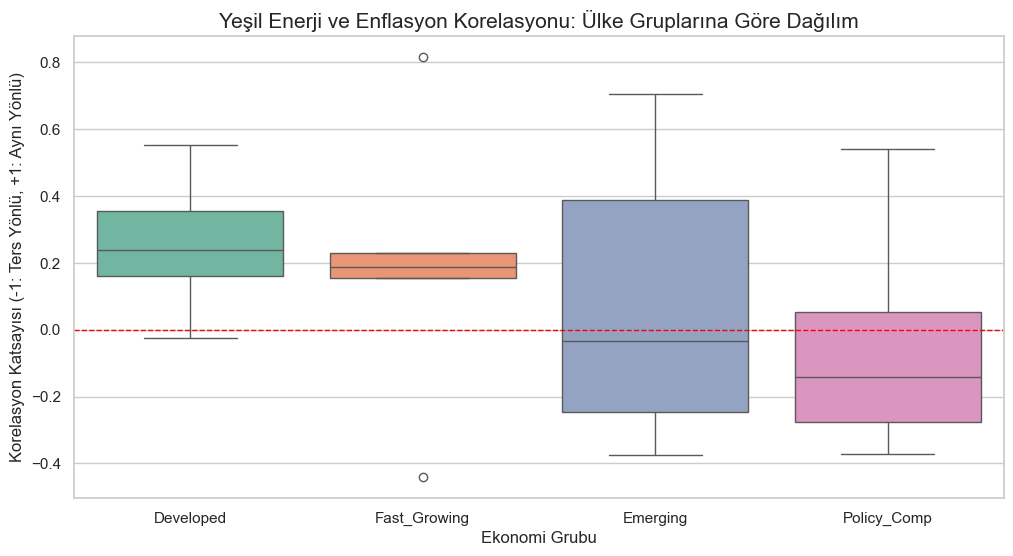

In [50]:
# --- HÜCRE 9: Yeşil Enerji Enflasyonu Nerede Tetikliyor? (Grup Bazlı Korelasyon) ---

# Her ülke için Yeşil Enerji ve Enflasyon arasındaki korelasyonu hesapla
correlations = []

for country in df['Country_Code'].unique():
    c_data = df[df['Country_Code'] == country]
    if len(c_data) > 10: # En az 10 yıllık veri olsun
        corr = c_data['Renewable_Energy_Consumption_Pct'].corr(c_data['Inflation_Consumer_Prices_Pct'])
        group = c_data['Region_Group'].iloc[0] # Ülkenin grubu
        correlations.append({'Country': country, 'Group': group, 'Correlation': corr})

corr_df = pd.DataFrame(correlations)

# Kutu Grafiği (Boxplot) ile Grupları Kıyasla
plt.figure(figsize=(12, 6))
sns.boxplot(x='Group', y='Correlation', data=corr_df, palette='Set2')
plt.axhline(0, color='red', linestyle='--', linewidth=1) # 0 Çizgisi (Nötr)

plt.title('Yeşil Enerji ve Enflasyon Korelasyonu: Ülke Gruplarına Göre Dağılım', fontsize=15)
plt.ylabel('Korelasyon Katsayısı (-1: Ters Yönlü, +1: Aynı Yönlü)')
plt.xlabel('Ekonomi Grubu')

# Türkiye'yi Göster
tur_corr = corr_df[corr_df['Country'] == 'TUR']
if not tur_corr.empty:
    tur_val = tur_corr['Correlation'].values[0]
    tur_group = tur_corr['Group'].values[0]
    # Türkiye'nin yerine nokta koy
    # Not: Seaborn boxplot x ekseni kategoriktir, manuel yerleştirme gerekebilir.
    # Basitlik için başlığa yazdırıyoruz:
    print(f"\n>>> Türkiye'nin Yeşil Enerji-Enflasyon Korelasyonu: {tur_val:.3f}")
    if tur_val > 0:
        print(">>> YORUM: Türkiye'de yeşil enerji arttıkça enflasyon da artma eğiliminde (Pozitif Korelasyon).")
    else:
        print(">>> YORUM: Türkiye'de yeşil enerji arttıkça enflasyon düşme eğiliminde.")

plt.show()

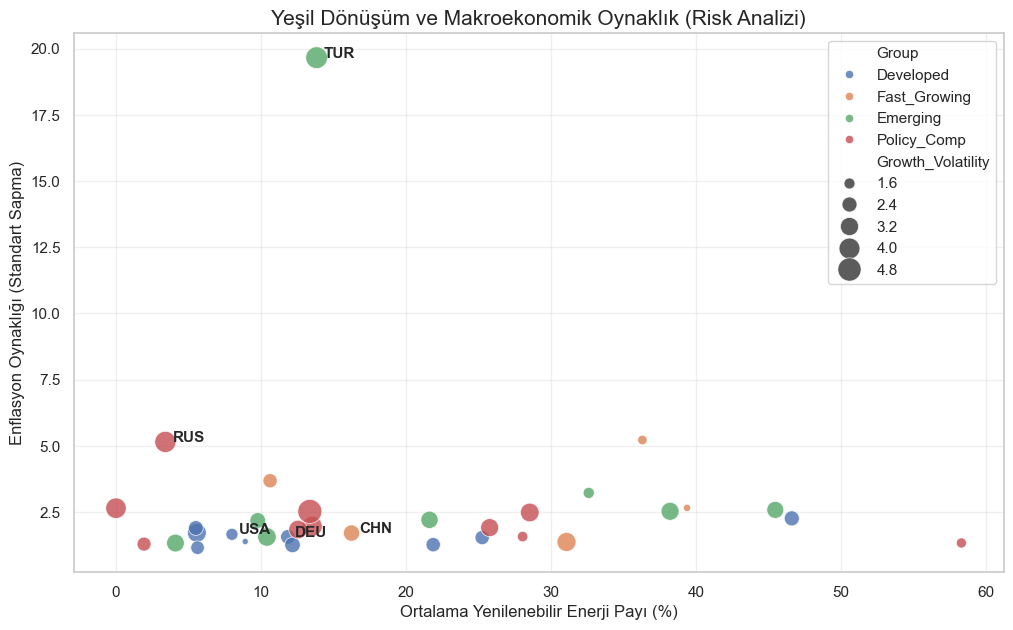

In [51]:
# --- HÜCRE 10: Büyüme ve Enflasyon Oynaklığı (Volatility Analysis) ---

# Oynaklığı (Standart Sapma) hesapla
volatility_df = df.groupby('Country_Code').agg({
    'GDP_Growth_Pct': 'std',
    'Inflation_Consumer_Prices_Pct': 'std',
    'Renewable_Energy_Consumption_Pct': 'mean', # Ortalama yeşil seviyesi
    'Region_Group': 'first'
}).reset_index()

volatility_df.columns = ['Country', 'Growth_Volatility', 'Inflation_Volatility', 'Green_Level', 'Group']

# Grafik: Enflasyon Oynaklığı vs. Yeşil Seviye
plt.figure(figsize=(12, 7))

sns.scatterplot(
    data=volatility_df,
    x='Green_Level',
    y='Inflation_Volatility',
    hue='Group',
    size='Growth_Volatility', # Baloncuk boyutu büyüme oynaklığı
    sizes=(20, 300),
    alpha=0.8,
    palette='deep'
)

# Önemli Ülkeleri Etiketle
for country in ['TUR', 'DEU', 'CHN', 'USA', 'ARG', 'RUS']:
    if country in volatility_df['Country'].values:
        row = volatility_df[volatility_df['Country'] == country].iloc[0]
        plt.text(row['Green_Level']+0.5, row['Inflation_Volatility'], country, fontsize=11, fontweight='bold')

plt.title('Yeşil Dönüşüm ve Makroekonomik Oynaklık (Risk Analizi)', fontsize=15)
plt.xlabel('Ortalama Yenilenebilir Enerji Payı (%)')
plt.ylabel('Enflasyon Oynaklığı (Standart Sapma)')
plt.grid(True, alpha=0.3)
plt.show()

# Yorum:
# Eğer sağ üst köşede (Yüksek Yeşil, Yüksek Oynaklık) ülkeler toplanıyorsa -> "Dengesiz Yeşil Geçiş"
# Türkiye'nin konumu ne kadar yüksekse, makroekonomik belirsizlik o kadar fazladır.